# Development notebook for processing sexual dimorphism data

In [1]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

# Table of Contents
1. [Introduction](#introduction)
2. [Data Loading](#data_loading)
3. [Filtering](#filtering)
    1. [Cell Exclusion](#cell_exclusion_l1)
    2. [Male vs. Female Gene Expression](#avg_bool_mf_df_sorted_l2)
    3. [Gene Exclusion](#gene_exclusion_l1)
4. [Feature Selection](feat_selection) 
    1. [CV analysis](#get_top_cv_genes)
5. [Preprocessing](#preprocessing) 
    1. [Log and Standerdize](#log_and_standerdize)
6. [Dimensionality Reduction](#dim_reduction)
    1. [PCA](#analyze_pca)
    2. [t-SNE](#tsne)
        1. [Computing Perplexity](#get_perplexity)
        2. [Visualization](#do_tsne)
7. [Clustering](#clustering)
    1. [DBSCAN](#dbscan)
        1. [Computing Epsilon](#get_epsilon)
        2. [Visualization](#do_dbscan)
    2. [Linkage](#linkage)
8. [Marker Genes](#markergenes)

## Introduction <a name="introduction"></a>

Analysis notebook for processing sexual dimorphism data. Each processing step calls a function from dimorph_processing.py

## Data Loading <a name="data_loading"></a>

Intialize metadata (meta_data_df), gene expression data (df), boolean gene expression data (df_bool), and status tracking (status_df)

In [2]:
meta_data_df, df, df_bool, status_df = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [3]:
df.shape

(27933, 79613)

In [4]:
meta_data_df.shape

(27, 79613)

In [5]:
meta_data_df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
Serial_Number,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Date_Captured,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,...,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,...,,,,,,,,,,


In [6]:
status_df

,completion_status
cell_exclusion (l1),NaN
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


## Filtering <a name="filtering"></a>

### Cell Exclusion <a name="cell_exclusion_l1"></a>

Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [7]:
df, df_bool, meta_data_df, status_df = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      meta_data_df = meta_data_df,
                                                      df_bool = df_bool,
                                                      df = df,
                                                      status_df = status_df)


Total cells reduced from 79613 to 43492


In [8]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [9]:
df.shape #rerun

(27933, 43492)

In [10]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


Sanity Check of known specific sex genes

In [11]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

True
True
True
True
True
True


### Male vs. Female Gene Expression <a name="avg_bool_mf_df_sorted_l2"></a>

num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


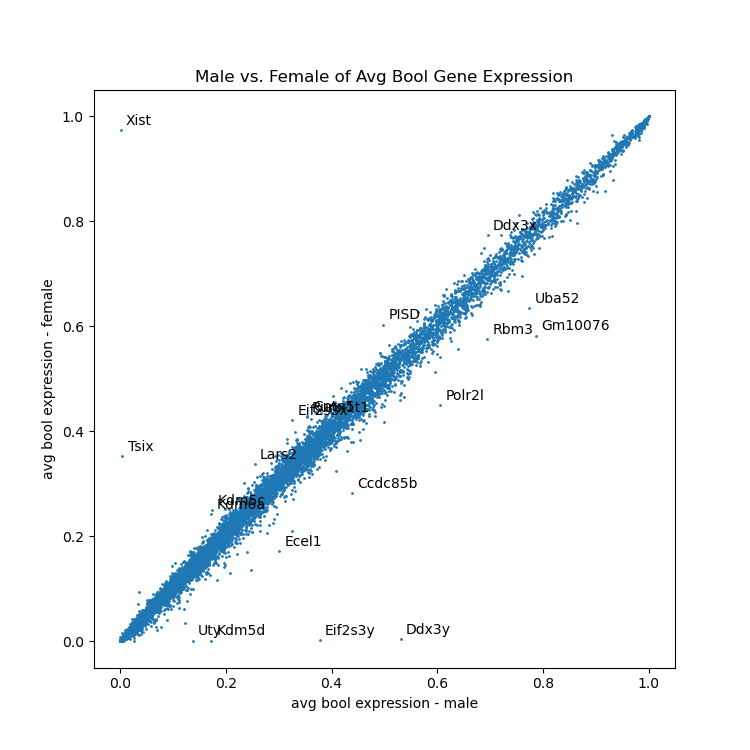

In [12]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = df_bool,
                                                              meta_data_df=meta_data_df,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### Gene Exclusion <a name="gene_exclusion_l1"></a> 

Keep only genes expressed in >10 cells, <50% of all cells

In [13]:
df, df_bool, meta_data_df, status_df = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=df_bool,
                                                     df = df,
                                                     meta_data_df = meta_data_df,
                                                     status_df = status_df)
df.head()

Total genes reduced from 27933 to 17081


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [14]:
meta_data_df.shape

(27, 43492)

In [15]:
df.shape

(17081, 43492)

In [16]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


#### Sanity Check of known specific sex genes

In [17]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

False
True
True
True
True
True


## Feature Selection <a name="feat_selection"></a> 

### CV Analysis <a name="get_top_cv_genes"></a> 

<IPython.core.display.Javascript object>


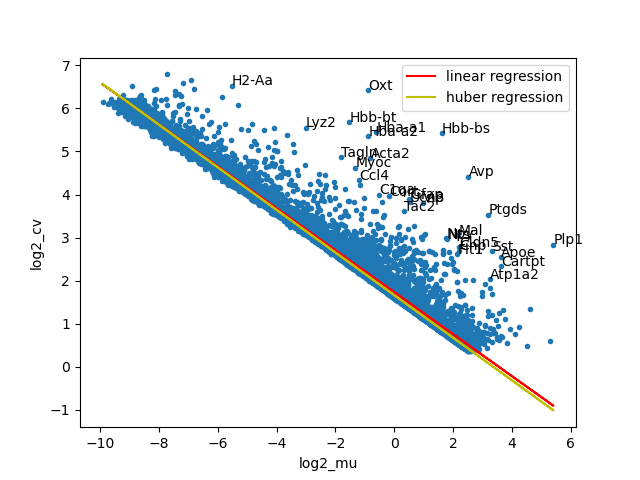

In [18]:
cv_df = dp.analyze_cv(df = df,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

In [19]:
cv_df.head()

,log2mu,log2cv,delta_cv
gene,,,
Hbb-bs,1.620289,5.429946,4.570352
Oxt,-0.879842,6.428204,4.330631
Avp,2.526425,4.414903,4.003995
Plp1,5.415903,2.831623,3.851485
Hba-a1,-0.615138,5.448019,3.481519


In [20]:
cv_df.shape

(17081, 3)

Use highest variation CV genes to get top genes

<IPython.core.display.Javascript object>


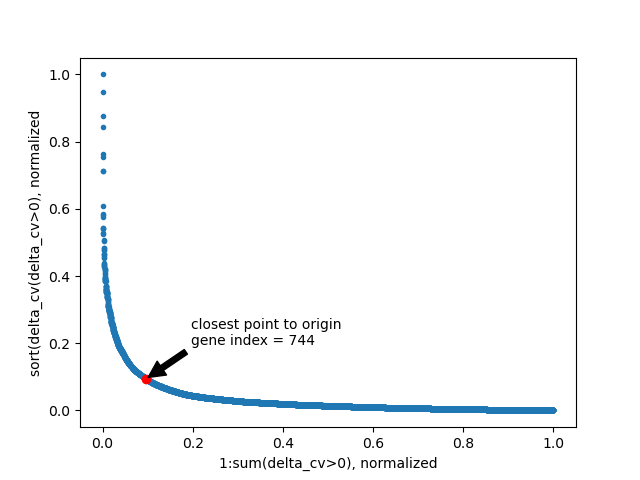

In [21]:
gene_index, df, status_df = dp.get_top_cv_genes(df = df, cv_df=cv_df, plot_flag=1, status_df=status_df)

In [22]:
df.shape

(744, 43492)

In [23]:
gene_index

744

In [24]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


utilize mean-variance relationship (PCA). Why this as opposed t mean-dropout relationship? see 'feature selection' section in :
https://www.nature.com/articles/s41467-019-13056-x

## Preprocessing <a name="preprocessing"></a> 

### Log and Standerdize <a name="#log_and_standerdize"></a> 

In [25]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oxt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avp,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plp1,0,0,2,0,0,0,1,0,0,0,...,1,0,0,1,0,71,0,0,0,1
Hba-a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df.shape

(744, 43492)

In [27]:
log_std_arr,status_df = dp.log_and_standerdize_df(df,status_df)

column (gene) mean after standardization: 0.00
column (gene) sigma after standardization: 1.00


In [28]:
log_std_arr.shape

(43492, 744)

In [29]:
log_std_arr.shape

(43492, 744)

In [30]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN


## Dimensionality Reduction <a name="dim_reduction"></a> 

### PCA <a name="analyze_pca"></a> 

Do PCA intially with num components = all genes, use normalized explained variance to select highest variation PCs and reduce gene expression to this dimension 

<IPython.core.display.Javascript object>


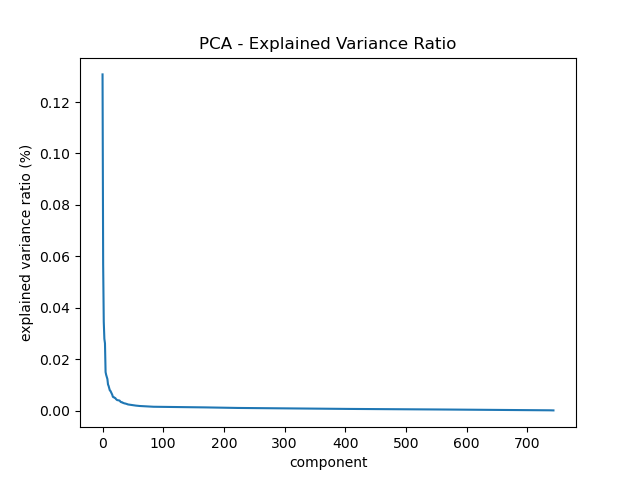

<IPython.core.display.Javascript object>


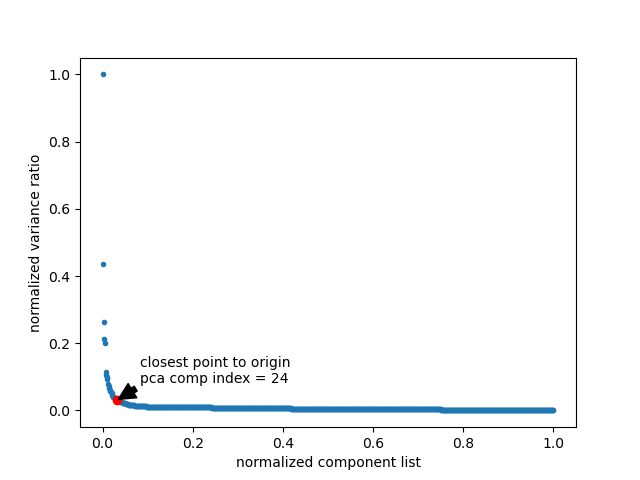

<IPython.core.display.Javascript object>


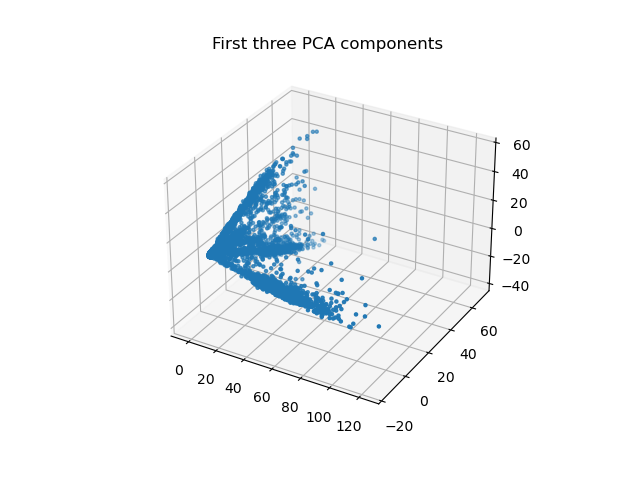

In [31]:
pca_index, arr_pca, status_df = dp.analyze_pca(arr = log_std_arr, #log_std_arr
                                               n_components=log_std_arr.shape[1], #log_std_arr.shape[1]
                                               optimize_n=True,
                                               plot_flag=1, 
                                               status_df=status_df)

In [32]:
arr_pca.shape

(43492, 24)

In [33]:
pca_index

24

In [34]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,NaN
do_tsne,NaN


In [35]:
'Apoe' in df.index

True

### t-SNE <a name="tsne"></a> 

#### Computing Perplexity <a name="get_perplexity"></a> 

Amit's method for determining perplexity param - 
1) compute pairwise distance matrix (n_cells x n_cells) from PCA reduced matrix.
2) sort columns by ascending values
3) compute angle from first point to last point of column values from index 1-500
4) use rotation matrix to rotate column values by this angle
5) take argmax for each rotated set of column values and store in list
6) take median of list created in step 5, this is perplexity value



<IPython.core.display.Javascript object>


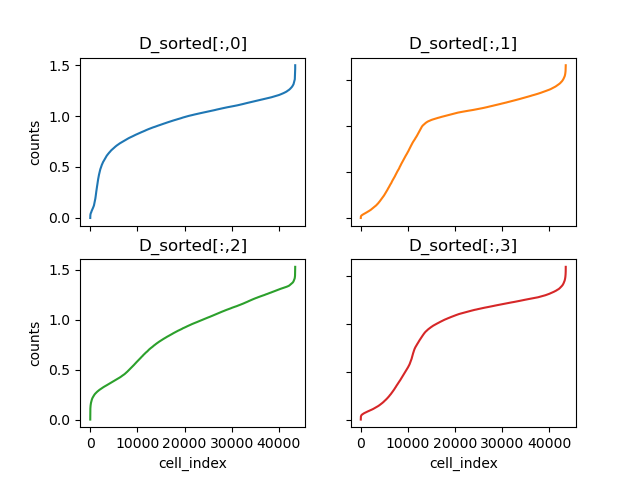

<IPython.core.display.Javascript object>


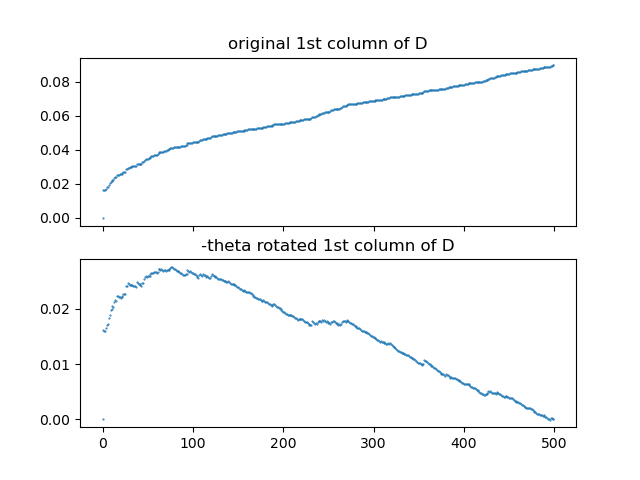

In [36]:
perplexity,status_df = dp.get_perplexity(pca_arr = arr_pca, cutoff=500, plot_flag=1, status_df = status_df)

In [37]:
perplexity

57.0

In [38]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,NaN


#### Visualize with t-SNE<a name="do_tsne"></a> 

In [39]:
arr_pca.shape

(43492, 24)

Do TSNE on pca reduced matrix using calculated perplexity. See https://www.nature.com/articles/s41467-019-13056-x for more details on parameter selection.

Note sklearn's learning rate is defined factor of 4 smaller than other implementations, see sklearn doc: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Create a t-SNE object

creating tsne object with the following parameters: 
n_components:2
n_iter: 1000
learning_rate: 50
early_exaggeration: 12
init: pca
perplexity: 57.0


<IPython.core.display.Javascript object>


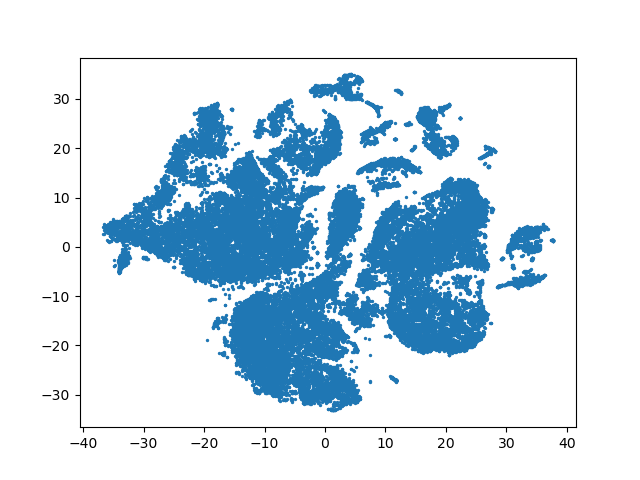

In [40]:
arr_tsne,status_df = dp.do_tsne(arr = arr_pca, 
                               n_components=2,
                               n_iter=1000,
                               learning_rate=50,
                               early_exaggeration=12,
                               init='pca', 
                               perplexity = perplexity,
                               status_df = status_df)

In [41]:
arr_tsne.shape

(43492, 2)

In [42]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,True


Sanity Check using known marker genes (from https://www.science.org/doi/full/10.1126/science.aaa1934)

In [43]:
df.shape

(744, 43492)

In [44]:
'Gad1' in df.index

True

gene index

In [45]:
np.where(df.index == 'Gad1')[0]

array([111])

In [46]:
x = df.iloc[np.where(df.index == 'Gad1')[0],:]>0

In [47]:
x.shape

(1, 43492)

In [48]:
x_arr = x.to_numpy()

In [49]:
x_arr[0]

array([ True, False, False, ...,  True,  True, False])

cells with postivie expression

In [50]:
df.columns[x_arr[0]]

Index(['AAACCCAAGAGCATAT-1_10X51_2', 'AAACGAAGTGAATAAC-1_10X51_2',
       'AAACGAAGTGACCTGC-1_10X51_2', 'AAACGCTTCCTGGCTT-1_10X51_2',
       'AAAGAACAGCATTGAA-1_10X51_2', 'AAAGAACCAGTAGATA-1_10X51_2',
       'AAAGAACTCCACTAGA-1_10X51_2', 'AAAGGATAGACCTCCG-1_10X51_2',
       'AAAGGATCATCTGTTT-1_10X51_2', 'AAAGGGCAGCAGATAT-1_10X51_2',
       ...
       'TTTCATGTCTAGGCAT-1_10X37_2', 'TTTCCTCGTGATTCTG-1_10X37_2',
       'TTTCGATTCGGTAAGG-1_10X37_2', 'TTTGGAGGTGTGTCCG-1_10X37_2',
       'TTTGGAGTCTCGCTTG-1_10X37_2', 'TTTGGTTTCCAATCTT-1_10X37_2',
       'TTTGTTGAGAAATTCG-1_10X37_2', 'TTTGTTGCAAGGTCAG-1_10X37_2',
       'TTTGTTGCACCGCTGA-1_10X37_2', 'TTTGTTGGTCCATAGT-1_10X37_2'],
      dtype='object', length=18449)

get indices

In [51]:
result = [idx for idx, val in enumerate(df.columns) if val in df.columns[x_arr[0]]]

In [52]:
len(result)

18449

In [53]:
tsne = TSNE(n_components=2,
            n_iter=1000,
            learning_rate=50,
           early_exaggeration=12,
           init='pca', 
           perplexity = perplexity)

# Apply t-SNE on the arr
X_tsne = tsne.fit_transform(arr_pca)

In [54]:
#Mpb, Gad1, Aldoc, Cldn5(good), Acta2 (good)

gene in df?  True
gene index:  [10]
num cells with positive expression of gene, Sst: 5021


<IPython.core.display.Javascript object>


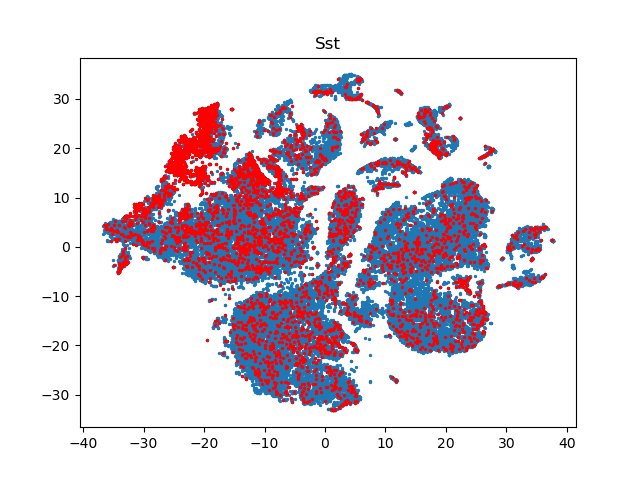

In [55]:
gene = 'Sst'
print('gene in df? ', gene in df.index)
print ('gene index: ', np.where(df.index == gene)[0])

#boolean array where True = gene postively expressed
x = df.iloc[np.where(df.index == gene)[0],:]>0
       
x_arr = x.to_numpy()
#use array of cell names to get cell index       
result = [idx for idx, val in enumerate(df.columns) if val in df.columns[x_arr[0]]]
print (f'num cells with positive expression of gene, {gene}:', len(result))

#visualise tsne
ax, fig = plt.subplots()
plt.title(gene)
fig.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 2)
fig.scatter(X_tsne[result,0], X_tsne[result,1], s = 2, c = 'r')
plt.show()

In [57]:
val.iloc[0,:]

AAACCCAAGAGCATAT-1_10X51_2    0
AAACCCAAGCCTCAGC-1_10X51_2    0
AAACCCACACAACGTT-1_10X51_2    0
AAACCCATCACTAGCA-1_10X51_2    0
AAACGAACACTCCGAG-1_10X51_2    1
                             ..
TTTGTTGAGAAATTCG-1_10X37_2    0
TTTGTTGCAAGGTCAG-1_10X37_2    0
TTTGTTGCACCGCTGA-1_10X37_2    0
TTTGTTGGTCCATAGT-1_10X37_2    0
TTTGTTGGTTGCGAAG-1_10X37_2    0
Name: Sst, Length: 43492, dtype: int64

## Clustering <a name="clustering"></a>

### DBSCAN <a name="dbscan"></a>

#### Computing Epsilon <a name="get_epsilon"></a> 

In [59]:
arr_tsne

array([[-18.818428  ,  23.38903   ],
       [ 25.507416  ,   9.313436  ],
       [ -0.43467605, -16.690489  ],
       ...,
       [ -8.670972  ,   6.6759686 ],
       [-10.270293  ,  13.481847  ],
       [ -3.935029  ,  -6.4704204 ]], dtype=float32)

In [60]:
type(arr_tsne)

numpy.ndarray

In [61]:
arr_tsne.shape

(43492, 2)

In [62]:
def compute_eps(minpts, eps_prc, arr):
    '''Amit's method for computing epsilon parameter used in dbscan:
        1) compute distance matrix for input arr
        2) sort columns by ascending values
        3) determine knn_radius for each point in order to satisfy min_pts (get sorted row value @ row = minpts)
        Parameters
    ----------
    minpts: int
        The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
    eps_prc: int
        epsilon percintile
    arr: numpy.ndarray
        2D input array, typically output from tsne
    Returns
    -------
    sorted_ind: 1-D array
        indexes that order the matrix
    '''
    D = squareform(pdist(arr, metric='euclidean'))
    D_sorted = np.sort(D, axis=0)
    knn_rad = D_sorted[minpts,:]
    epsilon = float(np.percentile(knn_rad, eps_prc))
    print ('params for dbscan')
    print ('minpts: ', minpts)
    print ('epsilon: ', str(epsilon) + '\n')
    return epsilon, minpts

Alternate method - calculate avg distance between each point and its n_neighbors (equal to min_pts), plot, and select point of max curvature 

In [63]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(arr_tsne)
distances, indices = neighbors_fit.kneighbors(arr_tsne)

<IPython.core.display.Javascript object>


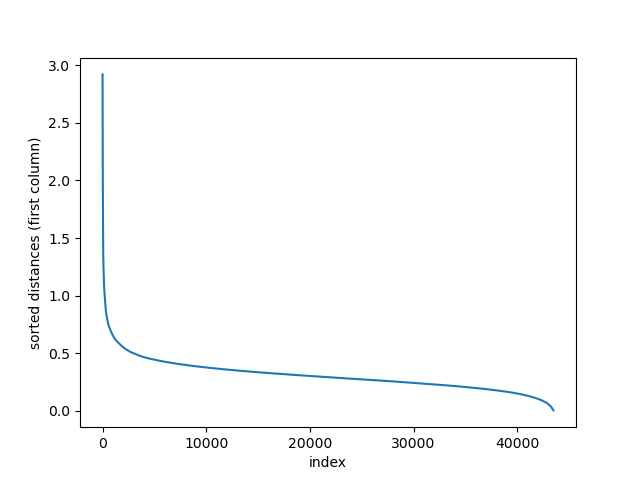

In [64]:
distances = np.flip(np.sort(distances, axis=0))
distances_c1 = distances[:,1]
fig,ax = plt.subplots()
plt.plot(distances_c1)
plt.xlabel('index')
plt.ylabel('sorted distances (first column)')
plt.show()

#### Visualize DBScan Clusters <a name="do_dbscan"></a> 

Use scikit-learn implementaton: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [161]:
def do_dbscan(epsilon, minpts, arr):
    ''' Do dbscan using scikit-learn implementation:
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
        Parameters
    ----------
    epsilon:
        The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    minpts: int
        The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
    arr: numpy.ndarray
        2D input array, typically output from tsne
    Returns
    -------
    labels: 1-D array
       Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.
    n_clusters_: int
        number of clusters (noise cluster removed)
    '''
    print (f"running dbscan with epsilon: {epsilon}  and minpts: {minpts}")
    db = DBSCAN(eps=epsilon, min_samples=minpts).fit(arr)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    
    arr_df = pd.DataFrame(arr, columns=['tsne-1','tsne-2'])
    #remove noise were label = -1
    arr_df_noise_rm = arr_df.drop(np.ravel(np.where(labels==-1)))
    labels_noise_rm = (db.labels_[db.labels_!=-1])
    
    fig,ax = plt.subplots()
    p = sns.scatterplot(data = arr_df_noise_rm,
                        x = 'tsne-1',
                        y= 'tsne-2',
                        hue = labels_noise_rm, 
                        legend = "full", 
                        palette = "deep",
                        s = 1)
    #sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
    # Annotate with cluster labels at the median of each cluster
    for label in set(labels_noise_rm):
        if label != -1:
            cluster_median = arr_df_noise_rm[labels_noise_rm == label].median()
            ax.annotate(label, cluster_median, fontsize=8, color='black',
                        ha='center', va='center', bbox=dict(boxstyle='round', alpha=0.2))
    
    p.legend_.remove()
    plt.title(f"Estimated number of clusters: {n_clusters_}, noise removed")
    plt.show()
    
    return labels_noise_rm, n_clusters_, arr_df_noise_rm

do dbscan clustering using minpts  = 10,15,20,25,30,35 and corresponding epsilon values for each

params for dbscan
minpts:  10
epsilon:  0.5069661298326913

running dbscan with epsilon: 0.5069661298326913  and minpts: 10
Estimated number of clusters: 73
Estimated number of noise points: 1068


<IPython.core.display.Javascript object>


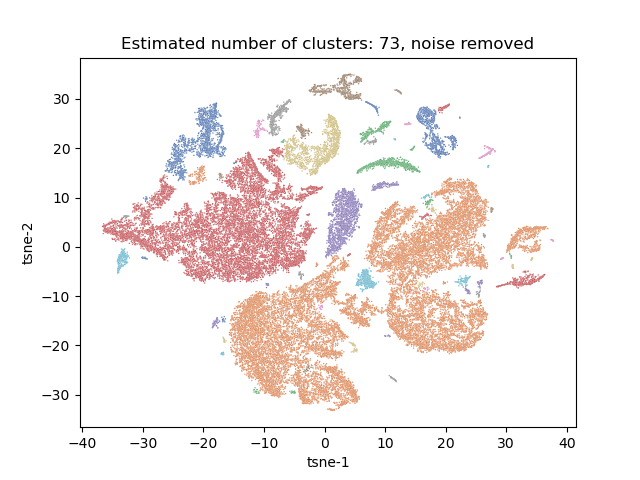

KeyboardInterrupt: 

In [75]:
for m in range(10,40,5):
    epsilon, minpts = dp.compute_eps(minpts = m, eps_prc=90, arr= arr_tsne)
    labels,n_clusters, arr = dp.do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne)

In [67]:
epsilon

0.9426763755767701

Pick case where minpts = 35

params for dbscan
minpts:  35
epsilon:  0.9426763755767701

running dbscan with epsilon: 0.9426763755767701  and minpts: 35
Estimated number of clusters: 30
Estimated number of noise points: 842


<IPython.core.display.Javascript object>


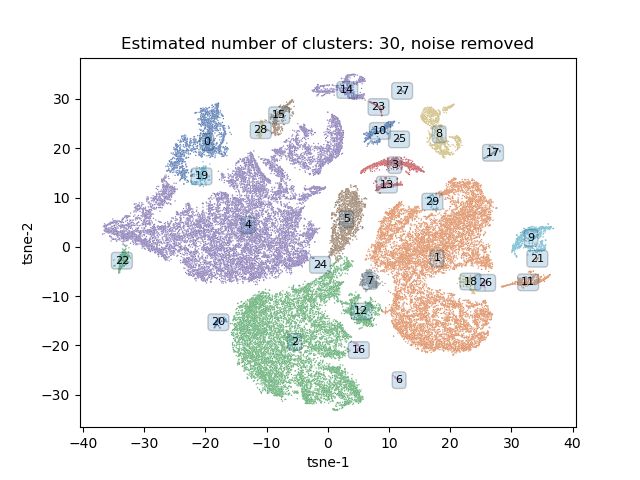

In [162]:
epsilon, minpts = dp.compute_eps(minpts = 35, eps_prc=90, arr= arr_tsne)
labels, n_clusters_, arr_df = do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne)

In [103]:
#numpy method to get cluster and pts per cluster
#c,p = np.unique(labels,return_counts=True)

In [105]:
cluster_pts = Counter(labels)

In [106]:
type(cluster_pts)

collections.Counter

View histogram showing number of pts per cluster

<IPython.core.display.Javascript object>


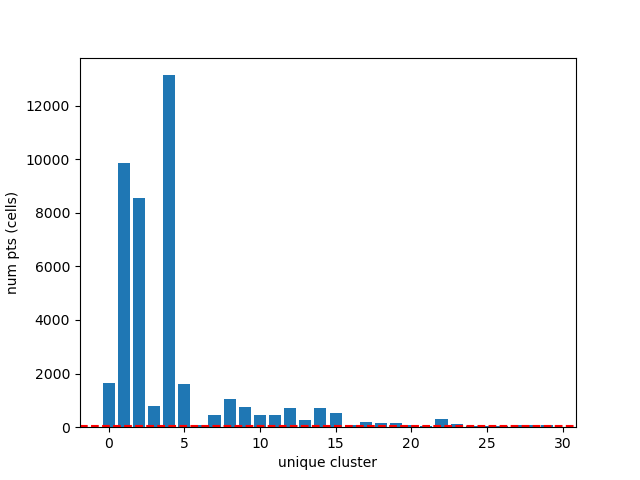

In [107]:
fig,ax = plt.subplots()
plt.bar(cluster_pts.keys(), cluster_pts.values())
plt.xlabel('unique cluster')
plt.ylabel('num pts (cells)')
#plt.ylim([0,100])
plt.axhline(y = minpts, color = 'r', linestyle = 'dashed') 
plt.show()

### Linkage <a name="linkage"></a>

Add cluster labels to each pair of points, sort by cluster.

In [108]:
df.shape

(744, 43492)

In [109]:
log_std_arr.shape

(43492, 744)

In [110]:
len(labels)

42650

In [111]:
len(arr_df)

42650

In [113]:
arr_df.insert(2, 'labels',labels)
arr_df_sorted = arr_df.sort_values(by = 'labels')
log_std_arr_df = pd.DataFrame(data = log_std_arr, index=df.T.index, columns=df.T.columns)
unique_labels = np.unique(labels) 
log_std_arr_df_new = pd.DataFrame(columns=log_std_arr_df.columns)

In [114]:
arr_df_sorted

,tsne-1,tsne-2,labels
0,-18.818428,23.389030,0
15443,-18.888908,24.698187,0
36107,-20.294727,25.886610,0
36129,-19.467392,23.416170,0
36148,-18.836823,19.456116,0
...,...,...,...
12391,17.657866,7.776618,29
24675,16.473904,10.031178,29
38972,17.723440,8.534841,29
36785,16.461981,10.072042,29


For every unique cluster, perform 1D tsne, then use ascending TSNE values to resort log_std_arr_df into log_std_arr_df_new

In [115]:
cluster_indices = []

In [117]:
for i in range(len(unique_labels)):
    #get indices corresponding to cells for each cluster
    ind = arr_df_sorted.index[np.where(arr_df_sorted['labels'] == i)]
    #print (len(ind))
    
    #use indices to extract gene expression data from cv-reduced, log, and standerdized matrix 
    arr = log_std_arr[np.array(ind),:]
    #print(arr.shape)

    #perform tsne to reduce to 1D
    tsne = TSNE(n_components=1, perplexity=30)
    # Apply t-SNE to reduce to 1 feature x num_cells. end up with a 1D vector for each unique label. 
    X_tsne = tsne.fit_transform(arr)
    #print(X_tsne.shape)

    #create temp dataframe of ind and 1D tsne
    tmp_df = pd.DataFrame({'ind':ind})
    tmp_df['X_tsne'] = X_tsne.tolist()
    #print (tmp_df.head())
    
    #sort by ascending 1D tsne values
    tmp_df_sorted = tmp_df.sort_values(by = 'X_tsne')
    #print (tmp_df_sorted.head())
    
    #reshuffle log_std_arr_sorted with new_ind
    new_ind = np.array(tmp_df_sorted['ind'])
    cluster_indices.append(new_ind)
    #print (new_ind)
    log_std_arr_df_new = pd.concat([log_std_arr_df_new,log_std_arr_df.iloc[new_ind,:]])
    print (log_std_arr_df_new.shape)


(1667, 744)


/tmp/ipykernel_1725373/59161584.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_std_arr_df_new = pd.concat([log_std_arr_df_new,log_std_arr_df.iloc[new_ind,:]])


(1667, 744)
(9861, 744)
(11528, 744)
(8552, 744)
(20080, 744)
(806, 744)
(20886, 744)
(13133, 744)
(34019, 744)
(1625, 744)
(35644, 744)
(100, 744)
(35744, 744)
(461, 744)
(36205, 744)
(1038, 744)
(37243, 744)
(760, 744)
(38003, 744)
(451, 744)
(38454, 744)
(467, 744)
(38921, 744)
(714, 744)
(39635, 744)
(272, 744)
(39907, 744)
(724, 744)
(40631, 744)
(539, 744)
(41170, 744)
(70, 744)
(41240, 744)
(193, 744)
(41433, 744)
(156, 744)
(41589, 744)
(162, 744)
(41751, 744)
(70, 744)
(41821, 744)
(37, 744)
(41858, 744)
(292, 744)
(42150, 744)
(138, 744)
(42288, 744)
(40, 744)
(42328, 744)
(35, 744)
(42363, 744)
(41, 744)
(42404, 744)
(89, 744)
(42493, 744)
(81, 744)
(42574, 744)
(76, 744)
(42650, 744)


In [118]:
log_std_arr_df_new.shape

(42650, 744)

In [119]:
log_std_arr_df_new.head()

gene,Hbb-bs,Oxt,Avp,Plp1,Hba-a1,Ptgds,Hba-a2,Hbb-bt,Acta2,Apoe,...,Ccdc153,Fam64a,Hpgds,Asic4,Fgfbp1,Rps27rt,Prox1os,Tmem47,Tns4,Dusp2
GAGAGGTTCCGAGGCT-1_10X37_2,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,0.569885,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,-0.721071,-0.226503,1.547294,-0.022524,-0.138418
TACCTCGCATGACACT-1_10X52_4,-0.063512,-0.098764,-0.182275,0.387706,-0.035357,0.990841,-0.047993,-0.028598,-0.076475,0.569885,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,-0.721071,3.388269,0.718921,-0.022524,-0.138418
GTTTGGACAACCTATG-1_10X51_4,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,-0.414040,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,3.743792,-0.226503,0.718921,-0.022524,-0.138418
ACGATCAAGTGGAATT-1_10X52_1,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,0.569885,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,-0.721071,-0.226503,-0.697193,-0.022524,-0.138418
GACAGCCTCCAGTGCG-1_10X37_1,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,-0.414040,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,0.767217,-0.226503,2.590921,-0.022524,-0.138418


Verify still standerdized

In [120]:
np.mean(np.array(log_std_arr_df_new.iloc[:1,:]))

0.07755731330458702

In [121]:
np.std(np.array(log_std_arr_df_new.iloc[:1,:]))

1.0374002921106273

Update Metadata

In [122]:
list(log_std_arr_df_new.index)

['GAGAGGTTCCGAGGCT-1_10X37_2',
 'TACCTCGCATGACACT-1_10X52_4',
 'GTTTGGACAACCTATG-1_10X51_4',
 'ACGATCAAGTGGAATT-1_10X52_1',
 'GACAGCCTCCAGTGCG-1_10X37_1',
 'TTTCGATCAATATCCG-1_10X52_2',
 'TACGCTCTCTAGCCTC-1_10X37_1',
 'ACCTACCGTCCAGCGT-1_10X52_4',
 'CATTCCGCAACACGTT-1_10X36_1',
 'CCGGACACAAACAGGC-1_10X36_1',
 'ACAACCATCGACGACC-1_10X52_3',
 'GTCCTCACATCAGCGC-1_10X38_1',
 'GAATCGTTCACTACTT-1_10X36_1',
 'GGGTCACAGCTAGTTC-1_10X36_2',
 'ACATCCCAGTGGCAGT-1_10X52_2',
 'AACAAAGGTCGGAACA-1_10X51_4',
 'TCCCAGTTCCTTTGAT-1_10X51_3',
 'CCTATCGCATCGTCCT-1_10X52_2',
 'TACACCCGTAGGAGGG-1_10X38_1',
 'TACAGGTCACCGTGAC-1_10X36_1',
 'AGAGCCCCACTAGTAC-1_10X51_3',
 'ACTATTCTCCTTCTGG-1_10X36_1',
 'GTGCGTGGTATCGCTA-1_10X52_3',
 'TGATCTTCAGGACAGT-1_10X52_3',
 'TTCCACGGTTGTTGTG-1_10X36_2',
 'TGATTCTTCCCTTCCC-1_10X36_2',
 'AGGTTGTTCCGTCACT-1_10X52_2',
 'ATGAGGGGTGCCGTTG-1_10X38_2',
 'GTGTGATCAGGCTCTG-1_10X51_1',
 'TGAGACTTCTAGACCA-1_10X51_2',
 'AGTTCCCCATGGCTAT-1_10X37_1',
 'AATGGCTGTACAGAGC-1_10X51_2',
 'TGGTTA

In [123]:
meta_data_df.shape

(27, 43492)

In [124]:
meta_data_df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
Serial_Number,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Date_Captured,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,...,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,...,,,,,,,,,,


In [125]:
meta_data_df = meta_data_df.loc[:,log_std_arr_df_new.index]

In [126]:
meta_data_df.head()

,GAGAGGTTCCGAGGCT-1_10X37_2,TACCTCGCATGACACT-1_10X52_4,GTTTGGACAACCTATG-1_10X51_4,ACGATCAAGTGGAATT-1_10X52_1,GACAGCCTCCAGTGCG-1_10X37_1,TTTCGATCAATATCCG-1_10X52_2,TACGCTCTCTAGCCTC-1_10X37_1,ACCTACCGTCCAGCGT-1_10X52_4,CATTCCGCAACACGTT-1_10X36_1,CCGGACACAAACAGGC-1_10X36_1,...,AGACAGGCACAACGTT-1_10X37_2,GGATCTAGTTCCCACT-1_10X35_2,AAAGTGACAATGTCTG-1_10X36_1,TCTAACTAGTCCTACA-1_10X36_1,CCACAAACAGAACTCT-1_10X36_1,AATCGACGTTAAGGAT-1_10X36_1,TACTTCAAGCAAGTGC-1_10X35_1,TACCTCGCATAGGTTC-1_10X35_1,ACCACAATCTCGGTCT-1_10X36_1,GTCAAACCACTGCACG-1_10X36_1
Serial_Number,68.0,104.0,100.0,101.0,67.0,102.0,67.0,104.0,65.0,65.0,...,68.0,64.0,65.0,65.0,65.0,65.0,63.0,63.0,65.0,65.0
Date_Captured,2019-11-25,05/31/20,05/31/20,05/31/20,2019-11-25,05/31/20,2019-11-25,05/31/20,2019-11-24,2019-11-24,...,2019-11-25,2019-11-20,2019-11-24,2019-11-24,2019-11-24,2019-11-24,2019-11-20,2019-11-20,2019-11-24,2019-11-24
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,,C57Bl/6,C57Bl/6,C57Bl/6,,C57Bl/6,,C57Bl/6,,,...,,,,,,,,,,


Insert cluster labels in meta data

In [127]:
cluster_labels = pd.DataFrame([list(arr_df_sorted['labels'])], columns=meta_data_df.columns, index = ['cluster_label'])
cluster_labels

,GAGAGGTTCCGAGGCT-1_10X37_2,TACCTCGCATGACACT-1_10X52_4,GTTTGGACAACCTATG-1_10X51_4,ACGATCAAGTGGAATT-1_10X52_1,GACAGCCTCCAGTGCG-1_10X37_1,TTTCGATCAATATCCG-1_10X52_2,TACGCTCTCTAGCCTC-1_10X37_1,ACCTACCGTCCAGCGT-1_10X52_4,CATTCCGCAACACGTT-1_10X36_1,CCGGACACAAACAGGC-1_10X36_1,...,AGACAGGCACAACGTT-1_10X37_2,GGATCTAGTTCCCACT-1_10X35_2,AAAGTGACAATGTCTG-1_10X36_1,TCTAACTAGTCCTACA-1_10X36_1,CCACAAACAGAACTCT-1_10X36_1,AATCGACGTTAAGGAT-1_10X36_1,TACTTCAAGCAAGTGC-1_10X35_1,TACCTCGCATAGGTTC-1_10X35_1,ACCACAATCTCGGTCT-1_10X36_1,GTCAAACCACTGCACG-1_10X36_1
cluster_label,0,0,0,0,0,0,0,0,0,0,...,29,29,29,29,29,29,29,29,29,29


In [128]:
# append new line to dataframe
meta_data_df = pd.concat([meta_data_df, cluster_labels])

In [129]:
meta_data_df

,GAGAGGTTCCGAGGCT-1_10X37_2,TACCTCGCATGACACT-1_10X52_4,GTTTGGACAACCTATG-1_10X51_4,ACGATCAAGTGGAATT-1_10X52_1,GACAGCCTCCAGTGCG-1_10X37_1,TTTCGATCAATATCCG-1_10X52_2,TACGCTCTCTAGCCTC-1_10X37_1,ACCTACCGTCCAGCGT-1_10X52_4,CATTCCGCAACACGTT-1_10X36_1,CCGGACACAAACAGGC-1_10X36_1,...,AGACAGGCACAACGTT-1_10X37_2,GGATCTAGTTCCCACT-1_10X35_2,AAAGTGACAATGTCTG-1_10X36_1,TCTAACTAGTCCTACA-1_10X36_1,CCACAAACAGAACTCT-1_10X36_1,AATCGACGTTAAGGAT-1_10X36_1,TACTTCAAGCAAGTGC-1_10X35_1,TACCTCGCATAGGTTC-1_10X35_1,ACCACAATCTCGGTCT-1_10X36_1,GTCAAACCACTGCACG-1_10X36_1
Serial_Number,68.0,104.0,100.0,101.0,67.0,102.0,67.0,104.0,65.0,65.0,...,68.0,64.0,65.0,65.0,65.0,65.0,63.0,63.0,65.0,65.0
Date_Captured,2019-11-25,05/31/20,05/31/20,05/31/20,2019-11-25,05/31/20,2019-11-25,05/31/20,2019-11-24,2019-11-24,...,2019-11-25,2019-11-20,2019-11-24,2019-11-24,2019-11-24,2019-11-24,2019-11-20,2019-11-20,2019-11-24,2019-11-24
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,,C57Bl/6,C57Bl/6,C57Bl/6,,C57Bl/6,,C57Bl/6,,,...,,,,,,,,,,
Project,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,...,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph
Group,Naïve-M,Breeder-M,Breeder-M,Breeder-F,Naïve-M,Breeder-F,Naïve-M,Breeder-M,Naïve-M,Naïve-M,...,Naïve-M,Naïve-F,Naïve-M,Naïve-M,Naïve-M,Naïve-M,Naïve-F,Naïve-F,Naïve-M,Naïve-M
ChipID,10X37,10X52,10X51,10X52,10X37,10X52,10X37,10X52,10X36,10X36,...,10X37,10X35,10X36,10X36,10X36,10X36,10X35,10X35,10X36,10X36
SampleID,10X37_2,10X52_4,10X51_4,10X52_1,10X37_1,10X52_2,10X37_1,10X52_4,10X36_1,10X36_1,...,10X37_2,10X35_2,10X36_1,10X36_1,10X36_1,10X36_1,10X35_1,10X35_1,10X36_1,10X36_1
DonorID,"DI4,DI5",DI-B3-M,DI-B1-M,DI-B3-F,"DI4,DI5",DI-B3-F,"DI4,DI5",DI-B3-M,DI3,DI3,...,"DI4,DI5","DI1,DI2",DI3,DI3,DI3,DI3,"DI1,DI2","DI1,DI2",DI3,DI3


Double check cluster indices

In [130]:
len(cluster_indices[1])

9861

In [131]:
len(np.where(meta_data_df.loc['cluster_label'] == 1)[0])

9861

In [132]:
log_std_arr_df.index[:10]

Index(['AAACCCAAGAGCATAT-1_10X51_2', 'AAACCCAAGCCTCAGC-1_10X51_2',
       'AAACCCACACAACGTT-1_10X51_2', 'AAACCCATCACTAGCA-1_10X51_2',
       'AAACGAACACTCCGAG-1_10X51_2', 'AAACGAACAGCGCGTT-1_10X51_2',
       'AAACGAACAGGACTTT-1_10X51_2', 'AAACGAAGTGAATAAC-1_10X51_2',
       'AAACGAAGTGACCTGC-1_10X51_2', 'AAACGCTAGCTCACTA-1_10X51_2'],
      dtype='object')

In [133]:
log_std_arr_df_new.shape

(42650, 744)

In [135]:
log_std_arr_df_new.index

Index(['GAGAGGTTCCGAGGCT-1_10X37_2', 'TACCTCGCATGACACT-1_10X52_4',
       'GTTTGGACAACCTATG-1_10X51_4', 'ACGATCAAGTGGAATT-1_10X52_1',
       'GACAGCCTCCAGTGCG-1_10X37_1', 'TTTCGATCAATATCCG-1_10X52_2',
       'TACGCTCTCTAGCCTC-1_10X37_1', 'ACCTACCGTCCAGCGT-1_10X52_4',
       'CATTCCGCAACACGTT-1_10X36_1', 'CCGGACACAAACAGGC-1_10X36_1',
       ...
       'AGACAGGCACAACGTT-1_10X37_2', 'GGATCTAGTTCCCACT-1_10X35_2',
       'AAAGTGACAATGTCTG-1_10X36_1', 'TCTAACTAGTCCTACA-1_10X36_1',
       'CCACAAACAGAACTCT-1_10X36_1', 'AATCGACGTTAAGGAT-1_10X36_1',
       'TACTTCAAGCAAGTGC-1_10X35_1', 'TACCTCGCATAGGTTC-1_10X35_1',
       'ACCACAATCTCGGTCT-1_10X36_1', 'GTCAAACCACTGCACG-1_10X36_1'],
      dtype='object', length=42650)

### Marker Genes<a name="markergenes"></a>

In [163]:
df = log_std_arr_df_new.T
df

,GAGAGGTTCCGAGGCT-1_10X37_2,TACCTCGCATGACACT-1_10X52_4,GTTTGGACAACCTATG-1_10X51_4,ACGATCAAGTGGAATT-1_10X52_1,GACAGCCTCCAGTGCG-1_10X37_1,TTTCGATCAATATCCG-1_10X52_2,TACGCTCTCTAGCCTC-1_10X37_1,ACCTACCGTCCAGCGT-1_10X52_4,CATTCCGCAACACGTT-1_10X36_1,CCGGACACAAACAGGC-1_10X36_1,...,AGACAGGCACAACGTT-1_10X37_2,GGATCTAGTTCCCACT-1_10X35_2,AAAGTGACAATGTCTG-1_10X36_1,TCTAACTAGTCCTACA-1_10X36_1,CCACAAACAGAACTCT-1_10X36_1,AATCGACGTTAAGGAT-1_10X36_1,TACTTCAAGCAAGTGC-1_10X35_1,TACCTCGCATAGGTTC-1_10X35_1,ACCACAATCTCGGTCT-1_10X36_1,GTCAAACCACTGCACG-1_10X36_1
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,...,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512
Oxt,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,...,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764
Avp,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,...,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275
Plp1,-0.406017,0.387706,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,0.387706,-0.406017,0.387706,...,-0.406017,0.387706,-0.406017,0.387706,0.387706,1.181428,-0.406017,0.387706,1.181428,0.387706
Hba-a1,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,...,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rps27rt,-0.721071,-0.721071,3.743792,-0.721071,0.767217,-0.721071,0.767217,1.637809,2.734626,-0.721071,...,-0.721071,0.767217,-0.721071,-0.721071,-0.721071,0.767217,-0.721071,0.767217,-0.721071,-0.721071
Prox1os,-0.226503,3.388269,-0.226503,-0.226503,-0.226503,3.388269,5.502775,3.388269,5.502775,7.003041,...,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503
Tmem47,1.547294,0.718921,0.718921,-0.697193,2.590921,-0.697193,2.590921,-0.697193,-0.697193,0.718921,...,-0.697193,0.718921,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193


Check order w/ known markers from literature

In [ ]:
#Mpb, Gad1, Aldoc, Cldn5(good), Acta2 (good)
#Slc17a7, Slc17a6, Slc32a1

In [211]:
gene = 'Cldn5'
print('gene in df? ', gene in df.index)
gene_index = np.where(df.index == gene)[0]
print ('gene index: ', gene_index)
#get row data
x = df.iloc[gene_index,:]
fig,ax = plt.subplots()
plt.plot(np.array(x.iloc[0,:]))
plt.show()

gene in df?  True
gene index:  [20]


<IPython.core.display.Javascript object>

Check Order by isolating cells for cluster 2

In [236]:
df_cluster2 = df.iloc[:,np.where(meta_data_df.loc['cluster_label',:] == 2)[0]]

In [237]:
df_cluster2

,CATAGACCAGCCTATA-1_10X36_1,TTTGACTTCCTAGCTC-1_10X38_1,TCACACCAGTGTTGTC-1_10X35_1,CGTGATATCGTTAGAC-1_10X35_1,CATACCCGTGGTAATA-1_10X35_2,AAATGGATCCGCATAA-1_10X35_1,CCCGAAGCAGGACGAT-1_10X51_2,CGAGGAAGTGACTCGC-1_10X36_2,TACCTGCAGTATGCAA-1_10X52_2,TTGAACGAGGGACAGG-1_10X36_1,...,TTCTAACCAGACCGCT-1_10X38_1,CGAATTGCACCCGTAG-1_10X38_1,TGGGTTAAGCATCAGG-1_10X35_1,CACCAAAGTGGGACAT-1_10X35_1,ACTTCCGTCACCACAA-1_10X35_1,GGACGTCGTCCTTAAG-1_10X36_1,ATCGATGGTATACAGA-1_10X36_1,CTATCTAGTCTATGAC-1_10X35_2,ACGGTTATCTGTGCTC-1_10X35_1,TTGTTGTGTCATACCA-1_10X38_1
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,...,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512
Oxt,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,...,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764
Avp,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,...,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275
Plp1,1.645726,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,...,0.387706,-0.406017,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,-0.406017,0.387706,-0.406017
Hba-a1,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,...,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rps27rt,-0.721071,0.767217,-0.721071,-0.721071,-0.721071,0.767217,0.767217,-0.721071,3.996689,0.767217,...,1.637809,1.637809,1.637809,0.767217,-0.721071,-0.721071,0.767217,1.637809,-0.721071,1.637809
Prox1os,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,...,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503
Tmem47,2.135035,1.547294,0.718921,0.718921,1.547294,0.718921,0.718921,-0.697193,0.718921,-0.697193,...,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193


In [165]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [166]:
cluster_indices

[array([42212, 22155, 16859, ...,  5002,  4491, 28249]),
 array([11223, 32020, 25450, ..., 20565, 30772, 25250]),
 array([34380, 31542, 25032, ..., 26927, 23114, 31510]),
 array([ 4566,  1821, 12542, 37169,  2755, 12705, 37725, 37034, 28983,
        39322,  6760, 31412,  6879, 10249,  8427, 30093, 39381, 41777,
         3356, 29437, 33214, 11157, 13002, 41983,   956,  8953,  8608,
        17245, 29174, 33014,  7590,  4451, 36839,  6599, 36217, 37949,
        29970,  4483,  2603, 40203, 36851,   867,  4956,  2206,  2792,
           49, 39693,  1295,  8576,  4373, 30217,  1636,  2439, 12302,
         4023, 11688,  7959,   616,  1805,  1881,  9120,  3696,  5251,
        40034, 39825, 30342, 30927,  4971,  1006, 42369,   704, 29819,
         5141,  2170,  1319, 39259,   503, 36974,   835,  5924, 11054,
        30226,   168,  1175, 36403,  3644, 36647,   421,  5314, 36177,
         5735, 33364,  2672, 38642, 40214, 36890, 37387, 40161,   331,
        37954,  1649,  6397, 36459,  1024,   371

In [167]:
len(cluster_indices[0])

1667

In [168]:
np.mean(np.arange(0,len(cluster_indices[0])))

833.0

In [169]:
np.mean(np.arange(len(cluster_indices[0]),len(cluster_indices[0])+len(cluster_indices[1])))

6597.0

Compute Marker genes

In [253]:
def compute_marker_genes(df):
    tmp = 0
    pos = [] #avg index for each cluster
    cluster_expr_ratios = np.zeros((len(df.index),len(cluster_indices))) #initialize for ratio of mean gene_expression per cluster/mean gene expression across all cells
    mean_per_gene = np.mean(df.loc[:,:], axis=1)

    cluster_mean_pos = np.zeros((len(df.index),len(cluster_indices))) #intialize for mean of all postive cells
    arr_pos_bin = np.array(df>0).astype(int) #create array of same dim, setting all positive values to 1, otherwise 0
    df_pos = pd.DataFrame(arr_pos_bin, index = df.index, columns = df.columns)

    for i, c in enumerate(cluster_indices):
        pos.append(np.mean(np.arange(tmp,tmp+len(c))))
        tmp+=len(c)
        cluster_mean_expr = np.mean(df.loc[:,meta_data_df.loc['cluster_label',:] == i], axis = 1)
        #print(cluster_mean_expr.shape)
        cluster_expr_ratios[:,i] = cluster_mean_expr/mean_per_gene

        cluster_mean_p = np.mean(df_pos.loc[:,meta_data_df.loc['cluster_label',:] == i], axis = 1)
        #print(cluster_mean_p.shape)
        cluster_mean_pos[:,i] = cluster_mean_p
        
    #set any cluster mean pos <0.2 to 0
    cluster_mean_pos[cluster_mean_pos<0.2] = 0
    
    #compute gene index arrays for three different weights
    xi0 = np.multiply(cluster_expr_ratios, (cluster_mean_pos**0.001))
    xi0_df = pd.DataFrame(data = xi0, index = df.index)
    xi0_ind_arr = np.column_stack((xi0_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0_df.columns))))
    xi0p5 = np.multiply(cluster_expr_ratios, (cluster_mean_pos**0.5))
    xi0p5_df = pd.DataFrame(data = xi0p5, index = df.index)
    xi0p5_ind_arr = np.column_stack((xi0p5_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0p5_df.columns))))
    xi1 = np.multiply(cluster_expr_ratios, (cluster_mean_pos**1))
    xi1_df = pd.DataFrame(data = xi1, index = df.index)
    xi1_ind_arr = np.column_stack((xi1_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi1_df.columns))))

    #convert each ind array to 1D vector, then concatenate and flip order
    #By default, flatten() uses row major order, use 'F' to change to column major
    ind_gr_tmp_mark = np.flip(np.concatenate([xi0_ind_arr.flatten('F'),xi0p5_ind_arr.flatten('F'),xi1_ind_arr.flatten('F')]))
    
    #get unique marker genes, preserving order
    marker_genes, idx = np.unique(ind_gr_tmp_mark, return_index=True)
    marker_genes_sorted = marker_genes[np.argsort(idx)]
    
    return marker_genes_sorted

In [171]:
len(pos)

30

In [172]:
pos

[833.0,
 6597.0,
 15803.5,
 20482.5,
 27452.0,
 34831.0,
 35693.5,
 35974.0,
 36723.5,
 37622.5,
 38228.0,
 38687.0,
 39277.5,
 39770.5,
 40268.5,
 40900.0,
 41204.5,
 41336.0,
 41510.5,
 41669.5,
 41785.5,
 41839.0,
 42003.5,
 42218.5,
 42307.5,
 42345.0,
 42383.0,
 42448.0,
 42533.0,
 42611.5]

In [173]:
cluster_expr_ratios.shape

(744, 30)

In [174]:
cluster_mean_pos.shape

(744, 30)

In [175]:
cluster_expr_ratios

array([[   1.45263321,    1.19264294,    0.86139581, ...,    2.56160897,
           2.56160897,    2.56160897],
       [ 143.53364235,   68.26855063,   34.17900217, ...,  255.37592157,
         255.37592157, -562.34811117],
       [-395.31504453,   -6.38515686, -209.46363749, ..., -508.72441863,
        -699.6849975 , -505.99976053],
       ...,
       [ -37.37518829,   33.37420298,   34.45061751, ..., -292.42179806,
        -134.28225834,  -59.59990045],
       [  52.65288574,  -15.72545977,   15.64734661, ...,  -50.65320665,
         -50.65320665,  -50.65320665],
       [  14.94620093,  -82.58237444,  115.86854205, ...,  207.78340449,
          94.94161528,  207.78340449]])

In [176]:
cluster_mean_pos

array([[7.19856029e-03, 9.32968259e-03, 1.19270346e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.19856029e-03, 1.18649224e-02, 1.40318054e-02, ...,
        0.00000000e+00, 0.00000000e+00, 5.26315789e-02],
       [4.43911218e-02, 8.39671433e-02, 6.43124415e-02, ...,
        3.37078652e-02, 1.23456790e-02, 2.63157895e-02],
       ...,
       [4.59508098e-01, 3.35158706e-01, 3.22848457e-01, ...,
        8.42696629e-01, 6.91358025e-01, 5.00000000e-01],
       [1.19976005e-03, 4.05638373e-04, 5.84658559e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.03959208e-02, 3.12341548e-02, 1.00561272e-02, ...,
        0.00000000e+00, 1.23456790e-02, 0.00000000e+00]])

meangrpos_mat(meangrpos_mat<0.2) = 0;
molenrich_mat(meanpergene==0 | isnan(meanpergene),:) = 0;

[~,xi0] = sort(molenrich_mat.*meangrpos_mat.^0.001,'descend');
[~,xi0p5] = sort(molenrich_mat.*meangrpos_mat.^0.5,'descend');
[~,xi1] = sort(molenrich_mat.*meangrpos_mat.^1,'descend');

In [177]:
np.where(cluster_mean_pos<0.2)

(array([  0,   0,   0, ..., 743, 743, 743]),
 array([ 0,  1,  2, ..., 27, 28, 29]))

In [178]:
len(np.where(cluster_mean_pos<0.2)[0])

18147

In [179]:
744*31

23064

In [180]:
cluster_mean_pos[0,0]

0.007198560287942412

In [181]:
cluster_mean_pos[cluster_mean_pos<0.2] = 0

In [182]:
cluster_mean_pos[0,0]

0.0

In [183]:
np.where(mean_per_gene==0)

(array([], dtype=int64),)

In [184]:
np.where(np.isnan(mean_per_gene))

(array([], dtype=int64),)

In [185]:
cluster_mean_pos**0.001

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.9992227 , 0.99890745, 0.99887007, ..., 0.99982887, 0.99963097,
        0.99930709],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [186]:
0.4595081**0.001

0.9992227035420426

In [187]:
xi0 = np.multiply(cluster_expr_ratios, (cluster_mean_pos**0.001))
xi0_df = pd.DataFrame(data = xi0, index = df.index)
xi0_ind_arr = np.column_stack((xi0_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0_df.columns))))

/tmp/ipykernel_1725373/1097832066.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0_ind_arr = np.column_stack((xi0_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0_df.columns))))


In [188]:
xi0p5 = np.multiply(cluster_expr_ratios, (cluster_mean_pos**0.5))
xi0p5_df = pd.DataFrame(data = xi0p5, index = df.index)
xi0p5_ind_arr = np.column_stack((xi0p5_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0p5_df.columns))))

/tmp/ipykernel_1725373/613219155.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0p5_ind_arr = np.column_stack((xi0p5_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0p5_df.columns))))


In [189]:
xi1 = np.multiply(cluster_expr_ratios, (cluster_mean_pos**1))
xi1_df = pd.DataFrame(data = xi1, index = df.index)
xi1_ind_arr = np.column_stack((xi1_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi1_df.columns))))

/tmp/ipykernel_1725373/116628981.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi1_ind_arr = np.column_stack((xi1_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi1_df.columns))))


In [190]:
xi0_ind_arr.shape

(744, 30)

In [191]:
xi0_ind_arr[0:5,0:5]

array([['Crhbp', 'Slc30a3', 'A330069E16Rik', 'Rasl10a', 'Sv2b'],
       ['Mpped1', 'Bcl11b', 'Ntng1', 'Slc30a3', 'Myh7'],
       ['Sst', 'Gpr101', 'Gpx3', 'Bcl11b', 'Col25a1'],
       ['Thsd7a', 'Car12', 'Otp', 'Hs3st4', 'Dlx1'],
       ['Lhx6', 'Rasl10a', 'Pbx3', 'Rprm', 'Gad2']], dtype=object)

convert each ind array to 1D vector, then concatenate and flip order

why flip? 

In [192]:
len(xi0_ind_arr.flatten())

22320

In [193]:
type(xi0_ind_arr.flatten())

numpy.ndarray

By default, flatten() uses row major order, use 'F' to change to column major

In [194]:
ind_gr_tmp_mark = np.flip(np.concatenate([xi0_ind_arr.flatten('F'),xi0p5_ind_arr.flatten('F'),xi1_ind_arr.flatten('F')]))

In [195]:
ind_gr_tmp_mark.shape

(66960,)

In [196]:
len(ind_gr_tmp_mark)

66960

In [197]:
len(np.unique(ind_gr_tmp_mark))

744

In [198]:
marker_genes, idx = np.unique(ind_gr_tmp_mark, return_index=True)

In [199]:
marker_genes

array(['1500015O10Rik', '1700031P21Rik', '1700047M11Rik', '1700066B19Rik',
       '2310022B05Rik', '2700038G22Rik', '2900052N01Rik', '3110035E14Rik',
       '3300002A11Rik', '4833423E24Rik', '4930519G04Rik', '8430408G22Rik',
       '9130230L23Rik', '9430020K01Rik', 'A230065H16Rik', 'A2m',
       'A330069E16Rik', 'A730046J19Rik', 'A830036E02Rik', 'AF251705',
       'AW112010', 'AY074887', 'Abcb1a', 'Abcc9', 'Abcg2', 'Abi3bp',
       'Acsbg1', 'Acta2', 'Acvrl1', 'Adamts1', 'Adamts4', 'Adarb2',
       'Adcy1', 'Adcyap1', 'Adgrf5', 'Adgrl4', 'Adra1b', 'Aebp1', 'Agbl2',
       'Agt', 'Ahnak', 'Aldh1a1', 'Aldh1a3', 'Aldoc', 'Anln', 'Anxa3',
       'Ap1s2', 'Apoc4', 'Apod', 'Apoe', 'Apold1', 'Aqp4', 'Arhgap31',
       'Arhgap36', 'Arhgap6', 'Arpc1b', 'Arx', 'Asic4', 'Aspa', 'Atf3',
       'Atp13a5', 'Atp1a2', 'Aurkb', 'Avp', 'B230312C02Rik', 'B2m',
       'B930036N10Rik', 'BC026585', 'BC048546', 'BC051077', 'Bcan',
       'Bcas1', 'Bcl11a', 'Bcl11b', 'Bcl2a1b', 'Bdnf', 'Bfsp2', 'Bhlhe22',
   

In [200]:
marker_genes_sorted = marker_genes[np.argsort(idx)]

In [201]:
marker_genes_sorted

array(['C1ql3', 'Sv2b', 'Neurod2', 'Bdnf', 'Etv1', 'Myh7', 'Zbtb18',
       'Slc17a7', 'Pcdh11x', 'Nptx1', 'Lpl', 'Socs2', 'Ecel1', 'Nrn1',
       'Prdm8', '3110035E14Rik', 'Junb', 'Gfra1', 'Nfix', 'Nrp1',
       'Col6a1', 'Nr4a1', 'Nfib', 'Fosb', 'Neurod1', 'Rasl11a', 'Fos',
       'Btg2', 'Mylk', 'Nefm', 'Plp1', 'Cnr1', 'Adcy1', 'Nov', 'Cadps2',
       'Mbp', 'B930036N10Rik', 'Kitl', 'Dcn', 'Ramp1', 'Zeb2', 'Hmbs',
       'Bcl11a', 'Dusp1', 'Hs3st4', 'Gm13889', 'Kctd12', 'Serpine2',
       'Cxcl12', 'Necab1', 'Ier2', 'Nfia', 'Lmo3', 'Rasgrp1', 'Pcgf2',
       'Mgp', 'Meis2', 'Gm3764', 'Pla2g7', 'Cd24a', 'Rorb', 'Tmem47',
       'Igfbp4', 'Mmd2', 'Rab3b', 'Grb14', 'Ramp2', 'Sox9', 'Car4',
       'Foxq1', 'Plagl1', 'Lrpprc', 'Mpped2', 'Mt2', 'Reln', 'Ier3',
       'Arhgap31', 'Dbi', 'Id2', 'Sirt2', 'Slc1a3', 'Pcp4l1', 'Htra1',
       'Gstm1', 'Tmem80', 'Gfod2', 'Ptprz1', 'Sox4', 'Cytl1', 'Creb3l1',
       'Slc26a7', 'P2ry12', 'Aspa', 'Slc6a13', 'Gm36266', 'Fam83a',
       'Pou3f1', 'En

In [254]:
marker_genes_sorted = compute_marker_genes(df)

/tmp/ipykernel_1725373/2553048346.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0_ind_arr = np.column_stack((xi0_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0_df.columns))))
/tmp/ipykernel_1725373/2553048346.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0p5_ind_arr = np.column_stack((xi0p5_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0p5_df.columns))))
/tmp/ipykernel_1725373/2553048346.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an erro

In [255]:
marker_genes_sorted

array(['C1ql3', 'Sv2b', 'Neurod2', 'Bdnf', 'Etv1', 'Myh7', 'Zbtb18',
       'Slc17a7', 'Pcdh11x', 'Nptx1', 'Lpl', 'Socs2', 'Ecel1', 'Nrn1',
       'Prdm8', '3110035E14Rik', 'Junb', 'Gfra1', 'Nfix', 'Nrp1',
       'Col6a1', 'Nr4a1', 'Nfib', 'Fosb', 'Neurod1', 'Rasl11a', 'Fos',
       'Btg2', 'Mylk', 'Nefm', 'Plp1', 'Cnr1', 'Adcy1', 'Nov', 'Cadps2',
       'Mbp', 'B930036N10Rik', 'Kitl', 'Dcn', 'Ramp1', 'Zeb2', 'Hmbs',
       'Bcl11a', 'Dusp1', 'Hs3st4', 'Gm13889', 'Kctd12', 'Serpine2',
       'Cxcl12', 'Necab1', 'Ier2', 'Nfia', 'Lmo3', 'Rasgrp1', 'Pcgf2',
       'Mgp', 'Meis2', 'Gm3764', 'Pla2g7', 'Cd24a', 'Rorb', 'Tmem47',
       'Igfbp4', 'Mmd2', 'Rab3b', 'Grb14', 'Ramp2', 'Sox9', 'Car4',
       'Foxq1', 'Plagl1', 'Lrpprc', 'Mpped2', 'Mt2', 'Reln', 'Ier3',
       'Arhgap31', 'Dbi', 'Id2', 'Sirt2', 'Slc1a3', 'Pcp4l1', 'Htra1',
       'Gstm1', 'Tmem80', 'Gfod2', 'Ptprz1', 'Sox4', 'Cytl1', 'Creb3l1',
       'Slc26a7', 'P2ry12', 'Aspa', 'Slc6a13', 'Gm36266', 'Fam83a',
       'Pou3f1', 'En

In [202]:
len(marker_genes)

744

In [203]:
774*31

23994

In [204]:
xi0_ind_arr.shape

(744, 30)

In [256]:
df_marker = df.loc[marker_genes_sorted,:]

In [257]:
df_marker

,GAGAGGTTCCGAGGCT-1_10X37_2,TACCTCGCATGACACT-1_10X52_4,GTTTGGACAACCTATG-1_10X51_4,ACGATCAAGTGGAATT-1_10X52_1,GACAGCCTCCAGTGCG-1_10X37_1,TTTCGATCAATATCCG-1_10X52_2,TACGCTCTCTAGCCTC-1_10X37_1,ACCTACCGTCCAGCGT-1_10X52_4,CATTCCGCAACACGTT-1_10X36_1,CCGGACACAAACAGGC-1_10X36_1,...,AGACAGGCACAACGTT-1_10X37_2,GGATCTAGTTCCCACT-1_10X35_2,AAAGTGACAATGTCTG-1_10X36_1,TCTAACTAGTCCTACA-1_10X36_1,CCACAAACAGAACTCT-1_10X36_1,AATCGACGTTAAGGAT-1_10X36_1,TACTTCAAGCAAGTGC-1_10X35_1,TACCTCGCATAGGTTC-1_10X35_1,ACCACAATCTCGGTCT-1_10X36_1,GTCAAACCACTGCACG-1_10X36_1
gene,,,,,,,,,,,,,,,,,,,,,
C1ql3,-0.671879,0.380284,-0.008038,0.380284,-0.008038,-0.008038,-0.671879,-0.671879,-0.671879,-0.008038,...,1.784625,1.191759,1.432447,1.624634,2.331047,1.784625,1.044125,1.624634,1.983485,1.707966
Sv2b,-0.814287,-0.814287,-0.814287,0.169650,-0.814287,-0.814287,-0.814287,-0.814287,-0.814287,-0.814287,...,1.947974,1.153588,1.729154,1.470345,2.713091,2.304720,2.137525,2.137525,2.137525,2.454282
Neurod2,-0.532710,-0.532710,-0.532710,-0.532710,-0.532710,-0.532710,-0.532710,-0.532710,-0.532710,-0.532710,...,2.037428,0.752359,0.752359,0.752359,0.752359,0.752359,-0.532710,-0.532710,0.752359,2.037428
Bdnf,-0.528803,-0.528803,-0.528803,-0.528803,-0.528803,-0.528803,-0.528803,-0.528803,-0.528803,-0.528803,...,2.527896,-0.528803,-0.528803,-0.528803,0.787646,0.787646,-0.528803,-0.528803,-0.528803,-0.528803
Etv1,-0.498933,-0.498933,0.718390,-0.498933,0.718390,0.718390,-0.498933,-0.498933,-0.498933,-0.498933,...,2.327605,3.359891,3.865126,4.476832,0.718390,3.865126,1.430479,3.712315,3.712315,4.577215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gpr101,0.732845,-0.523278,-0.523278,1.467630,-0.523278,0.732845,-0.523278,0.732845,0.732845,-0.523278,...,-0.523278,-0.523278,2.393350,3.649473,-0.523278,2.723753,2.393350,-0.523278,4.259229,4.812642
Nr4a2,-0.295602,-0.295602,-0.295602,-0.295602,-0.295602,-0.295602,-0.295602,-0.295602,-0.295602,-0.295602,...,3.758567,-0.295602,2.917251,-0.295602,-0.295602,-0.295602,1.731482,-0.295602,-0.295602,-0.295602
Car12,-0.477185,-0.477185,-0.477185,-0.477185,-0.477185,-0.477185,-0.477185,-0.477185,-0.477185,-0.477185,...,1.601870,-0.477185,0.834553,1.601870,1.601870,2.568576,0.834553,0.834553,1.601870,-0.477185


In [207]:
df_marker.iloc[:1,:]

,GAGAGGTTCCGAGGCT-1_10X37_2,TACCTCGCATGACACT-1_10X52_4,GTTTGGACAACCTATG-1_10X51_4,ACGATCAAGTGGAATT-1_10X52_1,GACAGCCTCCAGTGCG-1_10X37_1,TTTCGATCAATATCCG-1_10X52_2,TACGCTCTCTAGCCTC-1_10X37_1,ACCTACCGTCCAGCGT-1_10X52_4,CATTCCGCAACACGTT-1_10X36_1,CCGGACACAAACAGGC-1_10X36_1,...,AGACAGGCACAACGTT-1_10X37_2,GGATCTAGTTCCCACT-1_10X35_2,AAAGTGACAATGTCTG-1_10X36_1,TCTAACTAGTCCTACA-1_10X36_1,CCACAAACAGAACTCT-1_10X36_1,AATCGACGTTAAGGAT-1_10X36_1,TACTTCAAGCAAGTGC-1_10X35_1,TACCTCGCATAGGTTC-1_10X35_1,ACCACAATCTCGGTCT-1_10X36_1,GTCAAACCACTGCACG-1_10X36_1
gene,,,,,,,,,,,,,,,,,,,,,
C1ql3,-0.671879,0.380284,-0.008038,0.380284,-0.008038,-0.008038,-0.671879,-0.671879,-0.671879,-0.008038,...,1.784625,1.191759,1.432447,1.624634,2.331047,1.784625,1.044125,1.624634,1.983485,1.707966


Check data is standerdized

In [208]:
np.mean(np.array(df_marker.iloc[:1,:]))

-0.0003278060582460689

In [209]:
np.std(np.array(df_marker.iloc[:1,:]))

0.9998852485710872

In [ ]:
df_marker.iloc[:10,:10]

<IPython.core.display.Javascript object>


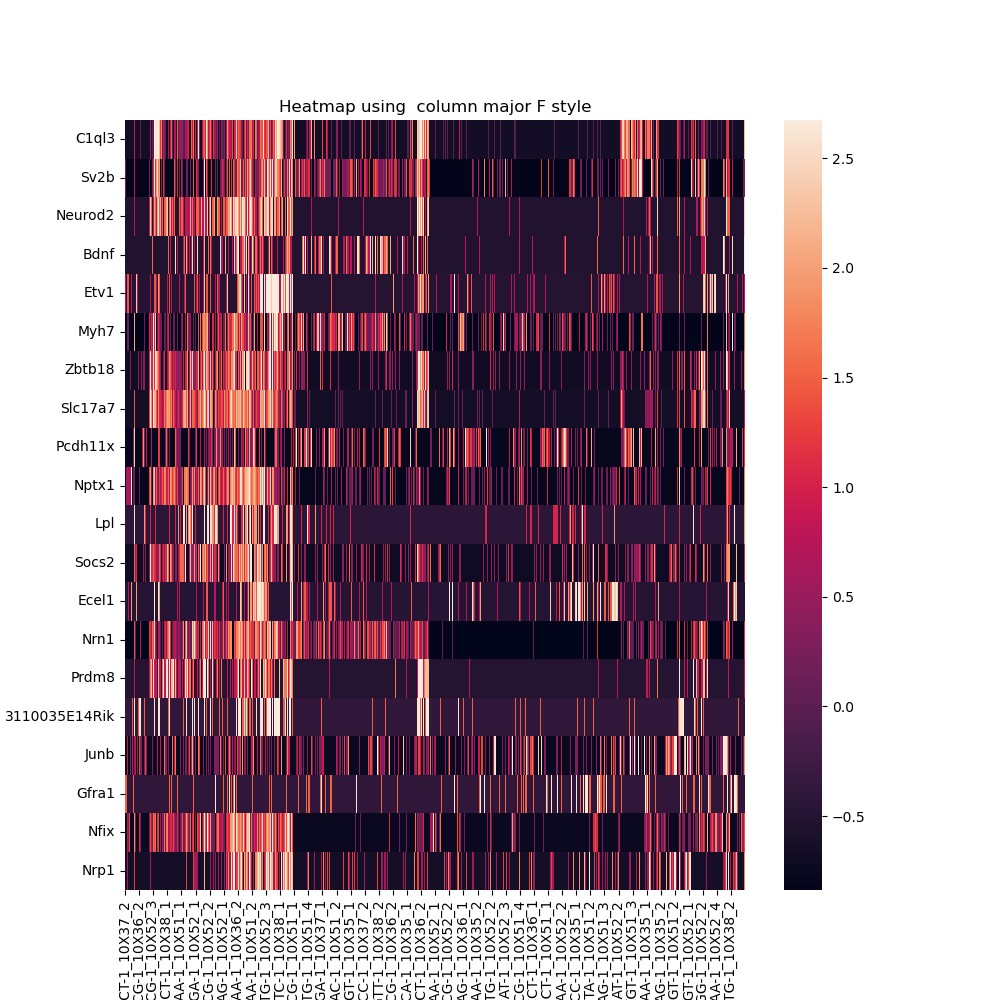

In [258]:
ax, fig = plt.subplots(figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
plt.title('Heatmap using  column major F style')
sns.heatmap(df_marker.iloc[:20,:], robust=True)
plt.show()

In [238]:
df_marker.shape

(744, 42650)

DEBUG Check order w/ known markers from literature

In [ ]:
#Mpb, Gad1, Aldoc, Cldn5(good), Acta2 (good)
#Slc17a7, Slc17a6, Slc32a1

gene in df?  True
gene index:  [20]


<IPython.core.display.Javascript object>


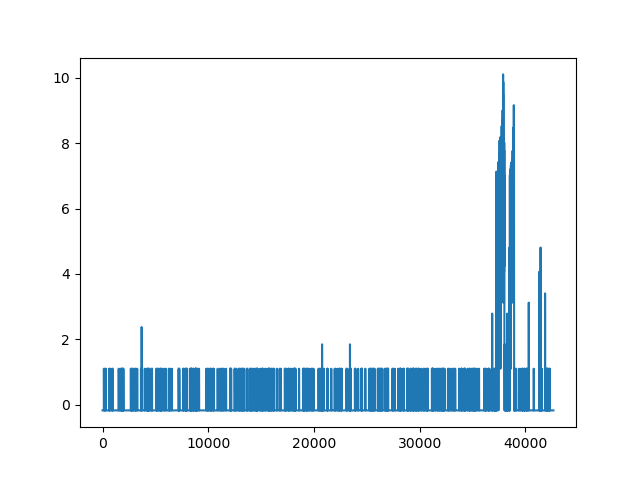

In [246]:
gene = 'Cldn5'
print('gene in df? ', gene in df.index)
gene_index = np.where(df.index == gene)[0]
print ('gene index: ', gene_index)
#get row data
x = df.iloc[gene_index,:]
fig,ax = plt.subplots()
plt.plot(np.array(x.iloc[0,:]))
plt.show()

DEBUG Check Order by isolating cells for cluster 2

In [247]:
df_cluster2 = df.iloc[:,np.where(meta_data_df.loc['cluster_label',:] == 2)[0]]

In [248]:
df_cluster2

,CATAGACCAGCCTATA-1_10X36_1,TTTGACTTCCTAGCTC-1_10X38_1,TCACACCAGTGTTGTC-1_10X35_1,CGTGATATCGTTAGAC-1_10X35_1,CATACCCGTGGTAATA-1_10X35_2,AAATGGATCCGCATAA-1_10X35_1,CCCGAAGCAGGACGAT-1_10X51_2,CGAGGAAGTGACTCGC-1_10X36_2,TACCTGCAGTATGCAA-1_10X52_2,TTGAACGAGGGACAGG-1_10X36_1,...,TTCTAACCAGACCGCT-1_10X38_1,CGAATTGCACCCGTAG-1_10X38_1,TGGGTTAAGCATCAGG-1_10X35_1,CACCAAAGTGGGACAT-1_10X35_1,ACTTCCGTCACCACAA-1_10X35_1,GGACGTCGTCCTTAAG-1_10X36_1,ATCGATGGTATACAGA-1_10X36_1,CTATCTAGTCTATGAC-1_10X35_2,ACGGTTATCTGTGCTC-1_10X35_1,TTGTTGTGTCATACCA-1_10X38_1
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,...,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512
Oxt,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,...,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764
Avp,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,...,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275
Plp1,1.645726,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,...,0.387706,-0.406017,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,-0.406017,0.387706,-0.406017
Hba-a1,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,...,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rps27rt,-0.721071,0.767217,-0.721071,-0.721071,-0.721071,0.767217,0.767217,-0.721071,3.996689,0.767217,...,1.637809,1.637809,1.637809,0.767217,-0.721071,-0.721071,0.767217,1.637809,-0.721071,1.637809
Prox1os,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,...,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503,-0.226503
Tmem47,2.135035,1.547294,0.718921,0.718921,1.547294,0.718921,0.718921,-0.697193,0.718921,-0.697193,...,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193,-0.697193


In [249]:
marker_genes_sorted_cluster2 = compute_marker_genes(df_cluster2)

/tmp/ipykernel_1725373/4198415463.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0_ind_arr = np.column_stack((xi0_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0_df.columns))))
/tmp/ipykernel_1725373/4198415463.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0p5_ind_arr = np.column_stack((xi0p5_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0p5_df.columns))))
/tmp/ipykernel_1725373/4198415463.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an erro

In [250]:
len(marker_genes_sorted_cluster2)

744

In [251]:
df_marker_cluster2 = df_cluster2.loc[marker_genes_sorted_cluster2,:]

<IPython.core.display.Javascript object>


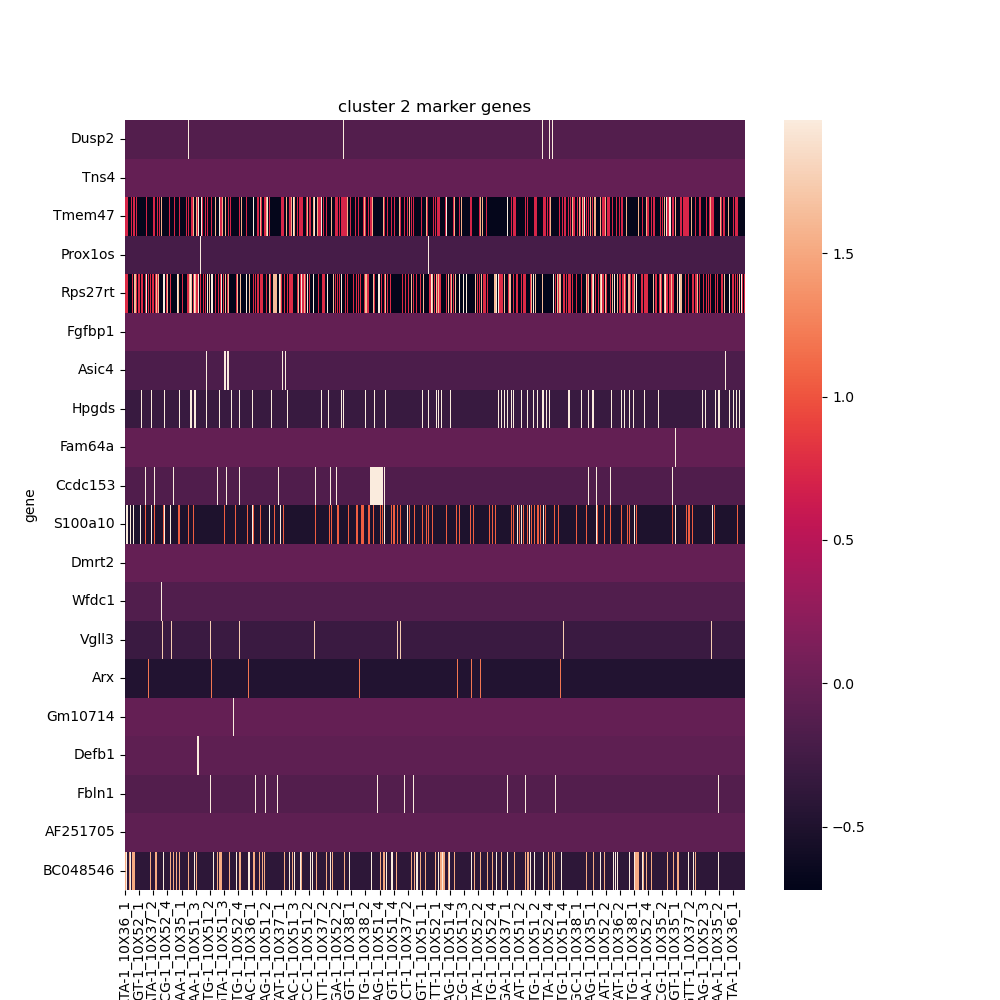

In [252]:
ax, fig = plt.subplots(figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
plt.title('cluster 2 marker genes')
sns.heatmap(df_marker_cluster2.iloc[:20,:], robust=True)
plt.show()